# Text Parsing, EDA, and Feature Engineering

The objective of this notebook is to explore the corpus and produce features for modeling. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
import wordcloud

In [2]:
# Read data
df = pd.read_csv('../data/interim/covid_articles_normalized.csv')

## Exploratory Data Analysis

### Length Analysis
It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. Some of the length measures for text data include:
* *word count*: counts the number of tokens in the text (separated by a space)
* *character count*: sum the number of characters of each token
* *sentence count*: count the number of sentences (separated by a period)
* *average word length*: sum of words length divided by the number of words (character count/word count)
* *average sentence length*: sum of sentences length divided by the number of sentences (word count/sentence count)

In [3]:
df_eda = df.copy(deep=True).dropna()

df_eda['word_count'] = df_eda["content"].apply(lambda x: len(str(x).split(" ")))
df_eda['char_count'] = df_eda["content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
#df_eda['sentence_count'] = df_eda["content"].apply(lambda x: len(str(x).split(".")))
df_eda['avg_word_length'] = df_eda['char_count'] / df_eda['word_count']
#df_eda['avg_sentence_lenght'] = df_eda['word_count'] / df_eda['sentence_count']
df_eda.head()

,title,topic_area,content,word_count,char_count,avg_word_length
0,Three Industrial Giants You Should Own In 2020,business,end year around corner past time think come ea...,564,3156,5.595745
1,Labor Stocks Are Going To Break Out In 2020,business,labor market one closely watch segment economy...,623,3539,5.680578
2,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",business,could forgive might think little big pile pie ...,603,3424,5.678275
3,"On the road to AI adoption, execs grapple with...",tech,kick ai item watch competition agenda adoption...,160,965,6.031250
4,Red Carpet Sustainability After Coronavirus Sh...,consumer,pandemic life return normal celebrity walk red...,738,4144,5.615176


What’s the distribution of those new variables with respect to the target? To answer that I’ll look at the bivariate distributions (how two variables move together). First, I shall split the whole set of observations into 3 samples (Politics, Entertainment, Tech), then compare the histograms and densities of the samples. If the distributions are different then the variable is predictive because the 3 groups have different patterns.
For instance, let’s see if the character count is correlated with the target variable:

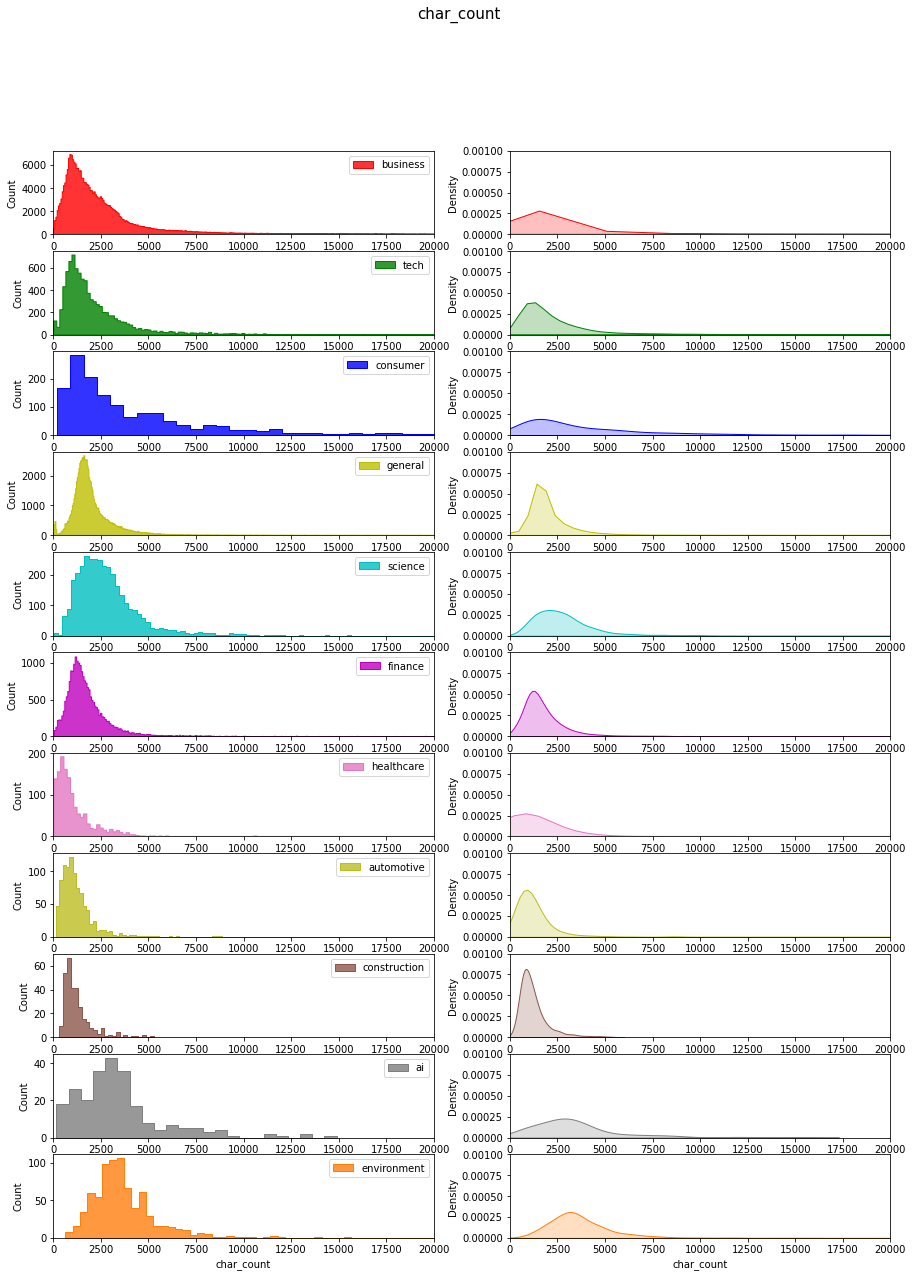

In [4]:
x, y = "char_count", "topic_area"
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(15,20))
fig.suptitle(x, fontsize=15)
colors = {'business':'r', 'tech':'g', 'consumer':'b', 'general':'y', 'science':'c', 'finance':'m',
          'healthcare':'tab:pink', 'automotive':'tab:olive', 'construction':'tab:brown', 'ai':'tab:gray',
          'environment':'tab:orange'}
count_rows = 0
for i in df_eda[y].unique():
    sns.histplot(df_eda[df_eda[y]==i][x], color = colors[i],
                 alpha=0.8, element="step",
                 label=i, ax=ax[count_rows, 0])
    sns.kdeplot(df_eda[df_eda[y]==i][x], shade=True, warn_singular=False,
                 color=colors[i], ax=ax[count_rows, 1])
    
    #ax[count_rows, 0].grid(True)
    ax[count_rows, 0].legend()
    ax[count_rows, 0].set_xlim(0,20000)
    
    #ax[count_rows, 1].grid(True)
    ax[count_rows, 1].set_xlim(0,20000)
    ax[count_rows, 1].set_ylim(0,0.001)
    count_rows += 1

plt.show();

### Named-Entity Recognition

NER (Named-entity recognition) is the process to tag named entities mentioned in unstructured text with pre-defined categories such as person names, organizations, locations, time expressions, quantities, etc.
Training a NER model is really time-consuming because it requires a pretty rich dataset. Luckily there is someone who already did this job for us. One of the best open source NER tools is SpaCy. It provides different NLP models that are able to recognize several categories of entities.

In [5]:
"""
The NER analysis takes too much time for the whole dataset. I executed the model once, and saved the results. 
In future iteration the data can be read from the saved file using this block of code. 
NOTE: the tags column is saved as string in the csv, to make sure the data can be parsed correctly, 
I applied the eval method on the tags column.
"""

#df_eda = pd.read_csv('../data/interim/covid_articles_NER.csv')

#df_eda["tags"] = [eval(x) for x in df_eda["tags"].tolist()]

In [6]:
## call model
ner = spacy.load("en_core_web_sm")
## tag text
text = df_eda["content"].iloc[0]
doc = ner(text)
## display result
spacy.displacy.render(doc, style="ent")

In [ ]:
## tag text and exctract tags into a list
df_eda["tags"] = df_eda["content"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )
## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
df_eda["tags"] = df_eda["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in df_eda["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df_eda["tags_"+feature] = df_eda["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))

## print result
df_eda.head()

In order to go deeper into the analysis, we need to unpack the column “tags” we created in the previous code. Let’s plot the most frequent tags for one of the headline categories:

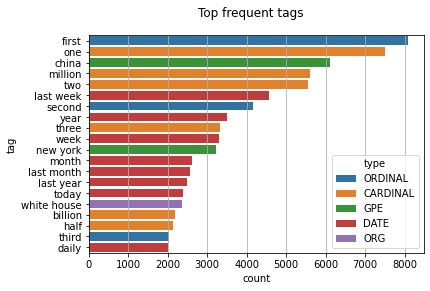

In [7]:
y = "finance"
top = 20

tags_list = df_eda[df_eda["topic_area"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
df_eda_tags = pd.DataFrame(map_lst, columns=['tag','type'])
df_eda_tags["count"] = 1
df_eda_tags = df_eda_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=df_eda_tags.iloc[:top,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [ ]:
df_eda.to_csv('../data/interim/covid_articles_NER.csv', index=False)

### Word Cloud
A nice way to visualize the text information is with a word cloud where the frequency of each tag is shown with font size and color.

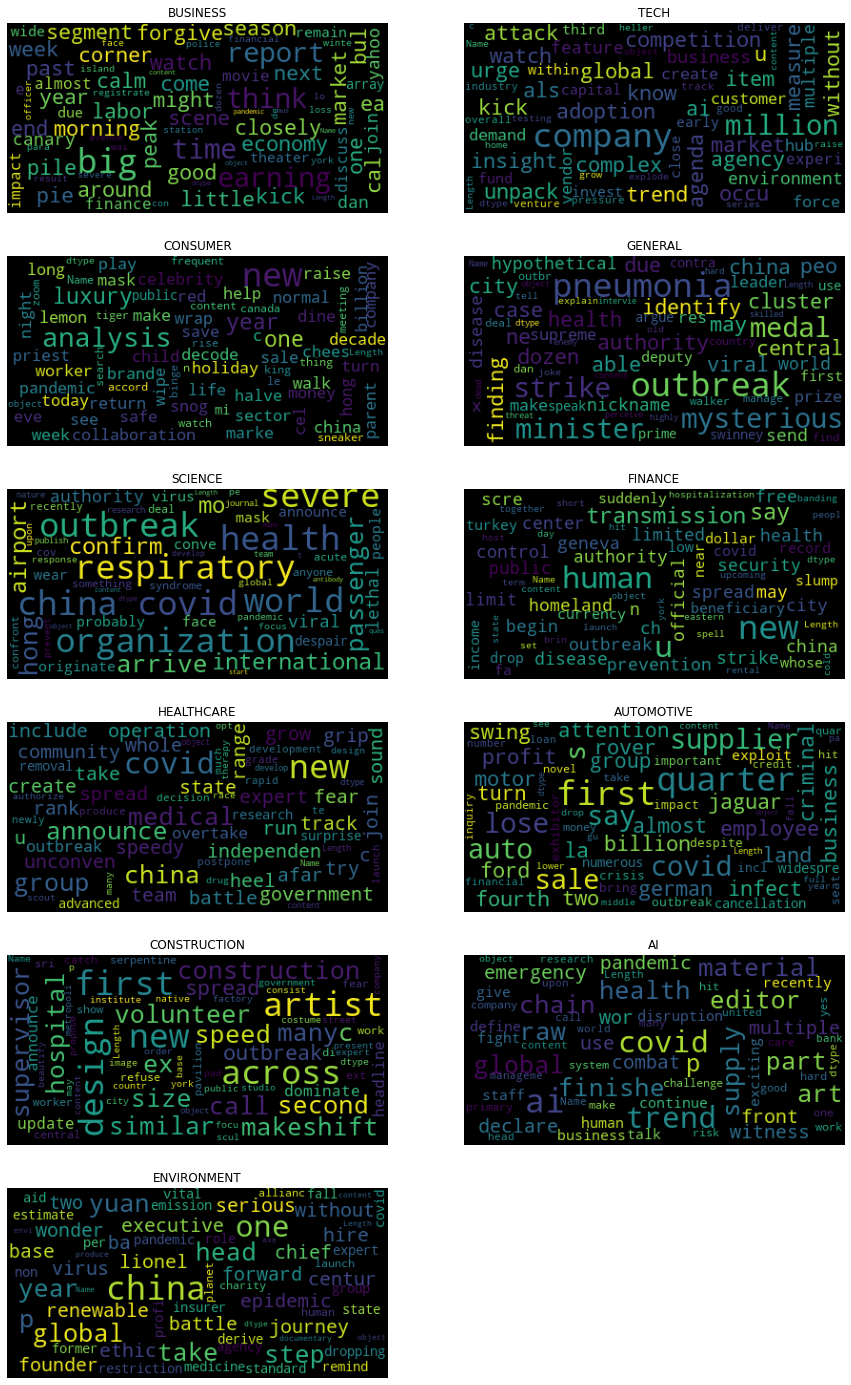

In [8]:
## Initialize a wordcloud instance
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)

topics = df_eda['topic_area'].unique()

fig = plt.figure(figsize=(15,25))
for i in range(len(topics)):
    ax = fig.add_subplot(6,2,i+1)
    wordcloud = wc.generate(str(df_eda[df_eda["topic_area"]==topics[i]]["content"]))

    ax.imshow(wordcloud)
    ax.axis('off')
    ax.title.set_text(topics[i].upper())

## Text Vectorization and Feature Engineering

Machine learning algorithms operate on a numeric feature space, expecting input as a two-dimensional array where rows are instances and columns are features. In order to perform machine learning on text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called feature extraction or more simply, vectorization, and is an essential first step toward language-aware analysis.

| Vectorization | Function | Good For | Considerations |
| :-- | :-- | :-- | :-- |
| **Frequency** | Counts term frequencies | Bayesian models | Most frequent words not always most informative |
|**One-Hot Encoding** | Binarizes term occurrence (0, 1) | Neural networks | All words equidistant, so normalization extra important |
| **TF–IDF** | Normalizes term frequencies across documents | General purpose | Moderately frequent terms may not be representative of document topics |
| **Distributed Representations** | Context-based, continuous term similarity encoding | Modeling more complex relationships | Performance intensive; difficult to scale without additional tools (e.g., Tensorflow) |

*Reference: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html*

## TF-IDF

TF–IDF, *term frequency–inverse document frequency*, encoding normalizes the frequency of tokens in a document with respect to the rest of the corpus. Therefore, it consider the relative frequency or rareness of tokens in the document against their frequency in other documents. The central insight is that meaning is most likely encoded in the more rare terms from a document.


Mathematically, we can define TF-IDF as tfidf = tf x idf, which can be expanded further to be represented as follows.

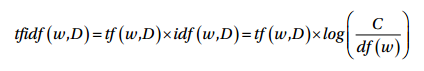

In [9]:
# Vectorize text
n_features = 1000

vectorizer = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features)
vectorized_text = vectorizer.fit_transform(df.content)
vectorized_text = vectorized_text.toarray()

In [10]:
words = vectorizer.get_feature_names_out()
words_df = pd.DataFrame(np.round(vectorized_text, 2), columns=words)
words_df.head()

,ability,able,accelerate,access,accord,accordance,account,accounting,achieve,acquire,...,worker,world,worth,would,write,year,yet,yield,york,young
0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.03,0.02,0.12,0.03,0.11,0.00,0.0
1,0.03,0.00,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,...,0.06,0.00,0.0,0.02,0.03,0.17,0.00,0.12,0.00,0.0
2,0.00,0.02,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.11,0.02,0.05,0.08,0.00,0.00,0.0
3,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.09,0.06,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,0.00,0.00,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,...,0.03,0.05,0.0,0.04,0.00,0.05,0.10,0.00,0.03,0.0


In [11]:
vec_df = pd.concat((df[['title', 'topic_area']], words_df), axis=1)
vec_df.head()

,title,topic_area,ability,able,accelerate,access,accord,accordance,account,accounting,...,worker,world,worth,would,write,year,yet,yield,york,young
0,Three Industrial Giants You Should Own In 2020,business,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.03,0.02,0.12,0.03,0.11,0.00,0.0
1,Labor Stocks Are Going To Break Out In 2020,business,0.03,0.00,0.0,0.0,0.04,0.0,0.0,0.0,...,0.06,0.00,0.0,0.02,0.03,0.17,0.00,0.12,0.00,0.0
2,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",business,0.00,0.02,0.0,0.0,0.02,0.0,0.0,0.0,...,0.00,0.00,0.0,0.11,0.02,0.05,0.08,0.00,0.00,0.0
3,"On the road to AI adoption, execs grapple with...",tech,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.09,0.06,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,Red Carpet Sustainability After Coronavirus Sh...,consumer,0.00,0.00,0.0,0.0,0.03,0.0,0.0,0.0,...,0.03,0.05,0.0,0.04,0.00,0.05,0.10,0.00,0.03,0.0


In [12]:
vec_df.to_csv('../data/interim/covid_articles_tfidf.csv', index=False)